# **Amazon Product Recommendation System**

--------------
## **Introduction**
--------------

Recommendation systems have become essential for businesses to enhance user engagement and drive sales. By providing personalized and relevant product suggestions, these systems help consumers navigate the overwhelming number of choices available online.

Amazon employs techniques like item-to-item collaborative filtering to analyze user behavior and generate high-quality, real-time suggestions, significantly enhancing the personalization of its platform.

In this project, I built a recommendation system to suggest products to customers based on their previous ratings of other items. Using a dataset of labeled Amazon product reviews, the objective was to extract meaningful insights and develop a system that enhances the online shopping experience through personalized recommendations.

-----------------------------
## **Dataset**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We will not use this column on this project

In [ ]:
# Installing surprise library
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357272 sha256=2a95f9494ca6127dcd2fe08473fce8c41b17dbf33b6f135e5e5d92f0f33f2b4e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries**

In [ ]:
# Libraries for numerical calculations
import numpy as np

#Libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data manipulation
import pandas as pd

# Subclass to handle missing keys in dictionaries
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Loading the datset
ratings = pd.read_csv('/content/drive/MyDrive/Github/ratings_Electronics.csv')

In [ ]:
ratings.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


**Observation:**

The dataframe doesn't have labels for the columns so we have to add them.

In [ ]:
# Adding the labels to the columns
ratings.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
ratings.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


We will drop the timestamp column as we will not be using it.

In [ ]:
ratings.drop('timestamp', axis=1, inplace=True)

In [ ]:
df = ratings.copy()

In [ ]:
df.shape

(7824481, 3)

Given the dataset's size, containing 7,824,481 observations, building a model directly with it is computationally impractical. Additionally, many users have rated only a small number of products, and some products have very few ratings. Therefore, **we can reduce the dataset by applying certain logical assumptions** to make it more manageable.

We will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings.

In [ ]:
# Getting the column containing the users
users = df.user_id

# Creating a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Getting the column containing the products
prods = df.prod_id

# Creating a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
# Checking the number of rows and columns
df_final.shape

(65290, 3)

**Observations:**

After removing all users with fewer than 50 ratings and the products that have fewer than 5 ratings, the number of observations decreased to 65,290.

### **Checking for missing values**

In [ ]:
# Checking for missing values
df_final.isna().sum()

,0
user_id,0
prod_id,0
rating,0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Observations:**

* None of the columns have missing values, and each column contains 65,290 non-null values.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating'
df_final['rating'].describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Observations:**
* All rating values are between 1 and 5.
* The average rating is 4.29.
* The distribution of this variable appears to be left-skewed.

### **Checking the rating distribution**

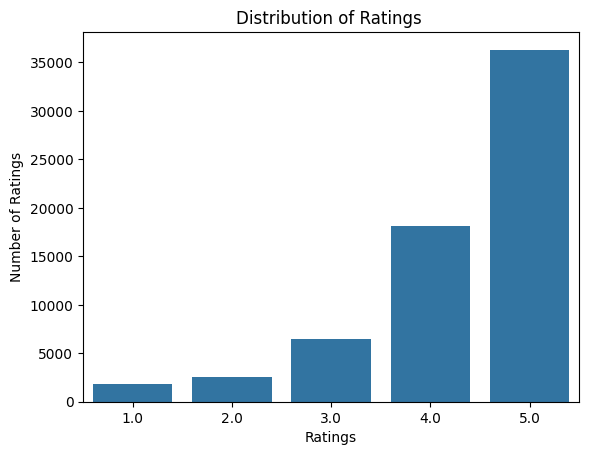

In [ ]:
# Creating the bar plot
sns.countplot(data=df_final,x="rating")
plt.title("Distribution of Ratings ")
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.show()

**Observations:**
* The distribution of ratings is left-skewed.
* Over 50% of ratings are equal to 5.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Checking the number of unique user id and product id in the data
df_final.nunique()

,0
user_id,1540
prod_id,5689
rating,5


**Observations:**
* There are 1,540 different user IDs and 5,689 different product IDs.

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)

,rating
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


**Observations:**
* The 10 users with the largest number of ratings have between 179 and 295 ratings.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculating the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
# Calculating the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()
# Creating a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
# Sorting the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)
# Showing the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interactions):
# Finding products with minimum number of interactions
  top_n = data[data['rating_count'] >= min_interactions]
# Sorting values with respect to average rating
  top_n = top_n.sort_values(by='avg_rating', ascending=False)
  return top_n[:n]



### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top5_50min = top_n_products(final_rating, 5, 50)
top5_50min


,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top5_100min = top_n_products(final_rating, 5, 100)
top5_100min

,avg_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class for parsing a file containing ratings
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# Class for tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# Class for splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# Class for implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# Class for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# Class for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# Class for implementing clustering-based recommendation system
from surprise import CoClustering

###Performance evaluation

In this scenario, it is important to balance precision and recall because, while it's crucial to provide recommendations that are relevant to the user, a company like Amazon offers products across many categories. Ensuring that the webpage shows a diverse range of relevant items can help motivate customers to explore new categories and discover products they might not have considered. By balancing precision and recall, the recommendation system can ensure that relevant items are recommended while also maximizing the diversity of products shown.

Based on this, we will use **F1 score** as the primary performance metric for this project.

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

**Relevant item:** A product that is actually rated higher than the threshold rating is relevant, if the actual rating is below the threshold then it is a non-relevant item.  

**Recommended item:** A product that's predicted rating is higher than the threshold is a recommended item, if the predicted rating is below the threshold then that product will not be recommended to the user.  


Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model. To compute **precision and recall**, **top k** predictions are taken under consideration for each user. We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # Mapping the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sorting user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)
    # Printing the overall precision
    print('Precision: ', precision)
    # Printing the overall recall
    print('Recall: ', recall)
    # Printing the F-1 score
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3))

Loading the `rating` dataset, which is a pandas DataFrame, into the format `surprise.dataset.DatasetAutoFolds`, which is required by the `surprise` library.

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 1)

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initializing the KNNBasic model using sim_options declared, Verbose = False
model = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fitting the model on the trainset
model.fit(trainset)

# Computing precision@k, recall@k, and f_1 score
precision_recall_at_k(model, k = 10, threshold = 3.5)

RMSE: 1.0390
Precision:  0.852
Recall:  0.785
F_1 score:  0.817


**Observations:**
* This model has an RMSE = 1.039.
* 85% of recommended products are relevant.
* 78% of relevant products are being recommended.
* The F1 score indicates that there is a good balance between the precision and recall for this model.


Let's predict rating for a user with **`userId=A3LDPF5FMB782Z` and `productId=1400501466`**. The user has already interacted with the product and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
model.predict("A3LDPF5FMB782Z", "1400501466", 5, verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

Let's now predict the rating for **`userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** The user has not interacted with the product.

In [ ]:
# Predicting rating for a sample user with a non interacted product
model.predict("A34BZM6S9L7QI4", "1400501466", verbose=False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.9969324864734994, details={'actual_k': 2, 'was_impossible': False})

**Observations:**
* For `userId=A3LDPF5FMB782Z` the estimation is not that close to the actual rating. The model estimated a rating of 3.8, while the actual rating was 5.
* For `userId=A34BZM6S9L7QI4` the model is predicting a rating of 2, and only 2 neighbors were found by the model to make this prediction.

### **Hyperparameter tuning the user-user similarity-based model**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options':{'name':['msd', 'cosine'],
              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)
# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9720350592314762
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


**Similarity-based model using tuned values of the hyperparameters**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
tuned_model = KNNBasic(sim_options = sim_options, k=30, min_k=6, verbose=False)
# Training the algorithm on the trainset
tuned_model.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(tuned_model)

RMSE: 0.9791
Precision:  0.842
Recall:  0.807
F_1 score:  0.824


**Observations:**
* RMSE for the test set decreased from 1.04 to 0.98.
* The tuned model achieves an F1 score of 0.824, compared to the baseline model's F1 score of 0.817
* The results above demostrate some improvement on the performance of the model.

**Predicting rating for the case in which the user has rated the product**

In [ ]:
# Use the optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
tuned_model.predict("A3LDPF5FMB782Z", "1400501466", 5, verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Predicting rating for the case in which the user has not rated the product**

In [ ]:
# Use the optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
tuned_model.predict("A34BZM6S9L7QI4", "1400501466", verbose=False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* For both cases, the tuned model couldn't find enough heighbors to make a reliable prediction and produced an estimate of 4.30.
* The baseline model predicted a rating of 3.8 for user "A3LDPF5FMB782Z" when the actual rating was 5, while the tuned model predicted a 4.3. The rating estimated by the tuned model is closer to the actual rating.
* For user "A34BZM6S9L7QI4", the baseline model predicted a rating of 2 while the tuned model estimated 4.3.
* Increasing the min_k to 6 made the tuned model more restrictive and less robust for cases with fewer neighbors. As a result, this model couldn't find enough neighbors to make a prediction based on similar users.

### **Identifying similar users to a given user (nearest neighbors)**

In [ ]:
# Finding the 5 most similar users to the user with ID 0
tuned_model.get_neighbors(0, k = 5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

The function below returns a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returning top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, tuned_model)
recommendations

[('B002WE4HE2', 5),
 ('B002WE6D44', 5),
 ('B0052SCU8U', 5),
 ('B003ES5ZUU', 4.951626961353037),
 ('B000Q8UAWY', 4.857142857142857)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df

,prod_id,predicted_ratings
0,B002WE4HE2,5.000000
1,B002WE6D44,5.000000
2,B0052SCU8U,5.000000
3,B003ES5ZUU,4.951627
4,B000Q8UAWY,4.857143


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items
item_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)
# Training the algorithm on the trainset
item_model.fit(trainset)
# Computing precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(item_model, k = 10, threshold = 3.5)

RMSE: 1.0345
Precision:  0.833
Recall:  0.768
F_1 score:  0.799


**Observations:**
* This model has an RMSE = 1.034.
* 83% of recommended products are relevant.
* 77% of relevant products are being recommended.
* The F1 score indicates that there is a good balance between the precision and recall for this model.

Let's predict rating for a user with **`userId=A3LDPF5FMB782Z` and `productId=1400501466`**. The user has already interacted with the product and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
item_model.predict("A3LDPF5FMB782Z", "1400501466", 5, verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1875, details={'actual_k': 16, 'was_impossible': False})

Let's now predict the rating for **`userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**. The user has not interacted with the product.

In [ ]:
# Predicting rating for a sample user with a non interacted product
item_model.predict("A34BZM6S9L7QI4", "1400501466", verbose=False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 3, 'was_impossible': False})

**Observations:**
* For `userId=A3LDPF5FMB782Z` the estimated rating is 4.18 while the true rating is 5. The prediction was made using 16 neighbors.
* For `userId=A34BZM6S9L7QI4` the model predicted a rating of 4 based on 3 neighbors.

### **Hyperparameter tuning the item-item similarity-based model**


In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                             'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1, )
# Fitting the data
gs.fit(data)
# Printing the best RMSE score
print(gs.best_score['rmse'])
# Printing the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9751143160434589
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


**Similarity-based model using tuned values of the hyperparameters**.

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
tuned_item_model = KNNBasic(sim_options=sim_options, k=30, min_k=6, verbose=False)
# Training the algorithm on the trainset
tuned_item_model.fit(trainset)
# Computing precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(tuned_item_model)

RMSE: 0.9804
Precision:  0.833
Recall:  0.8
F_1 score:  0.816


**Observations:**
* The RMSE has reduced from 1.03 to 0.98.
* The tuned model achieved the same precision as the baseline model.
* Recall and F1 score have shown slight improvements. Recall increased from 0.77 to 0.80, while F1 score rose from 0.80 to 0.82.


**Predicitng rating for the case in which the user has rated the product**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
tuned_item_model.predict("A3LDPF5FMB782Z", "1400501466", 5, verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.534653465346536, details={'actual_k': 16, 'was_impossible': False})

**Predicitng rating for the case in which the user has not rated the product**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
tuned_item_model.predict("A34BZM6S9L7QI4", "1400501466", verbose=False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.29674200818327, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* For user "A3LDPF5FMB782Z", the user-user similarity-based model was unable to find enough neighbors for the prediction and estimated a rating of 4.3. In contrast, the item-item similarity-based model found 16 neighbors and predicted a rating of 4.53.
* For user "A34BZM6S9L7QI4", none of the tuned models found enough neighbors for the prediction so both estimated a rating of 4.3.

### **Identifying similar items to a given item (nearest neighbors)**

In [ ]:
# Finding the 5 most similar items to the product with ID 0
tuned_item_model.get_neighbors(0, k = 5)

[9, 12, 13, 22, 28]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, tuned_item_model)
recommendations

[('1400532655', 4.29674200818327),
 ('1400599997', 4.29674200818327),
 ('9983891212', 4.29674200818327),
 ('B00000DM9W', 4.29674200818327),
 ('B00000J1V5', 4.29674200818327)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df

,prod_id,predicted_ratings
0,1400532655,4.296742
1,1400599997,4.296742
2,9983891212,4.296742
3,B00000DM9W,4.296742
4,B00000J1V5,4.296742


### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

### Singular Value Decomposition (SVD)

In [ ]:
# Using SVD matrix factorization
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Computing precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9114
Precision:  0.854
Recall:  0.802
F_1 score:  0.827


**Observations:**
* With an RMSE of 0.91, this model has achieved the lowest RMSE so far.
* It has a similar recall to the one obtained with the previous models we tested but it achieved a higher precision.
* The F1 score is very similar to the one obtained by the user-user similarity-based model.

**Predicting rating for the case in which the user has rated the product**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", 5, verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.262585198727372, details={'was_impossible': False})

**Observations:**
* The predicted rating is similar (slightly lower) than the estimate provided by the similarity-based models when there were not enough neighbors available for the prediction.

**Predicting rating for the case in which the user has not rated the product**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.430784168423419, details={'was_impossible': False})

**Observations:**
* For user A3LDPF5FMB782Z the predicted rating is similar (slightly lower) than the estimate provided by the similarity-based models when there were not enough neighbors available for the prediction.
* For user A34BZM6S9L7QI4 the predicted rating is 4.43 while the estimation form the previous models was 4.30.

### **Hyperparameter tuning the Matrix Factorization based model**

In [ ]:
# Setting the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
# Fitting data
gs_.fit(data)
# Best RMSE score
print(gs_.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8994314253791257
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


**Matrix Factorization based model using tuned values of the hyperparameters**

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
tuned_svd = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)
# Training the algorithm on the trainset
tuned_svd.fit( trainset)
# Computing precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(tuned_svd)

RMSE: 0.9034
Precision:  0.854
Recall:  0.797
F_1 score:  0.825


**Observations:**
* The RMSE decreased from 0.91 to 0.90, while precision, recall, and F1 score remained approximately the same as those achieved with the baseline SVD model.

**Predicting rating for the case in which the user has rated the product**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
tuned_svd.predict("A3LDPF5FMB782Z", "1400501466", 5, verbose=False)

Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2017895361381195, details={'was_impossible': False})

**Predicting rating for the case in which the user has not rated the product**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
tuned_svd.predict("A34BZM6S9L7QI4", "1400501466", verbose=False)

Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.2778394371468496, details={'was_impossible': False})

**Observations:**
* The estimation obtained with the baseline model for user "A3LDPF5FMB782Z" was slightly closer to the true rating than the estimation made by this model.
* For user "A34BZM6S9L7QI4", this model predicted a rating of 4.28 while the baseline model predicted 4.43.

### **Conclusion and Recommendations**

* The user-based and item-based models with tuned hyperparameters had a very similar performance. There was a slight difference in precision and recall but they achieved the same RMSE and F1 score.
* Both the user-based and item-based models reduced their RMSE after tuning their minimum and maximum number of neighbors to take into account for aggregation, and the similarity measure.
* When we tuned the hyperparameters for KNN, we set the minimum k to 6, but the models were unable to find enough neighbors to predict the rating of the product "1400501466" by user "A34BZM6S9L7QI4".   
* SVD achieved the lowest RMSE (0.9 for the model with tuned hyperparameters).
* The highest F1 score was also achieved by the SVD model, indicating it offers the best balance between precision and recall.
* The SVD model achieved the highest F1 score and provides the best trade-off between RMSE, precision, and recall. Therefore, my recommendation to the company is to implement an SVD model for their recommendation system.